following :

 https://langchain-ai.github.io/langgraph/tutorials/introduction/#setup

In [20]:
%pip install -U langgraph langsmith langchain_anthropic

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
%pip install python-dotenv langchain_groq


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [23]:
import getpass
import os
from dotenv import find_dotenv, load_dotenv

dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
groq_api_key = os.getenv("groq_api_key")
os.environ["groq_api_key"] = groq_api_key 

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("groq_api_key")

In [24]:
os.environ.get("groq_api_key")

'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'

In [25]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [26]:
from langchain_anthropic import ChatAnthropic
from langchain_groq import ChatGroq
#llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")

def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [27]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

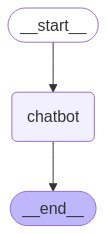

In [28]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [29]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hello! How can I help you today? 😄

Goodbye!


## PART 2

In [30]:
dotenv_path = find_dotenv()
load_dotenv(dotenv_path)
tavily_api_key = os.getenv("tavily_api_key")
os.environ["tavily_api_key"] = tavily_api_key

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("tavily_api_key")

In [31]:
%pip install -U tavily-python langchain_community

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [61]:
from langchain_community.tools.tavily_search import TavilySearchResults

tool = TavilySearchResults(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

[{'title': 'LangGraph Glossary - GitHub Pages',
  'url': 'https://langchain-ai.github.io/langgraph/concepts/low_level/',
  'content': 'In LangGraph, nodes are typically python functions (sync or async) where the first positional argument is the state, and (optionally), the second positional argument is a "config", containing optional configurable parameters (such as a thread_id).\nSimilar to NetworkX, you add these nodes to a graph using the add_node method:\n[](https://langchain-ai.github.io/langgraph/concepts/low_level/#__codelineno-7-1)from langchain_core.runnables import RunnableConfig [...] By composing Nodes and Edges, you can create complex, looping workflows that evolve the State over time. The real power, though, comes from how LangGraph manages that State. To emphasize: Nodes and Edges are nothing more than Python functions - they can contain an LLM or just good ol\' Python code.\nIn short: nodes do the work. edges tell what to do next. [...] Nodes: Python functions that enco

In [62]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


#llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [63]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [64]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

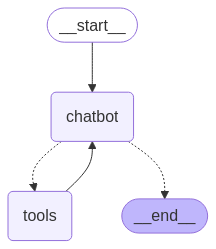

In [65]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [66]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 
Assistant: [{"title": "Average age of male gymnasts finalists from different OG held in ...", "url": "https://www.researchgate.net/figure/Average-age-of-male-gymnasts-finalists-from-different-OG-held-in-period-from-1980-to-2016_fig1_320508499", "content": "Average age (AA) of all male finalists (All-Around and Event Finalist) from the OG held in the period from 1980 to 2016, generally ranged from 22.6 (OG1988) to", "score": 0.42993253}, {"title": "What is the avg age breakdown of a DCA corps? : r/drumcorps - Reddit", "url": "https://www.reddit.com/r/drumcorps/comments/a45x40/what_is_the_avg_age_breakdown_of_a_dca_corps/", "content": "Bucs average age is in the low 20s I believe. I was in the OG group at 29 in 2017 (10ish oldest individuals) and had I marched last year, I", "score": 0.18374038}]
Assistant: It appears the information you are looking for is about the average age of gymnasts in the Olympics. 



Assistant: 
Assistant: [{"title": "Aging in dogs - Wikipedia", "ur

# part 3

In [38]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [44]:
from typing import Annotated

from langchain_anthropic import ChatAnthropic
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearchResults(max_results=2)
tools = [tool]
#llm = ChatAnthropic(model="claude-3-5-sonnet-20240620")
llm=ChatGroq(groq_api_key=groq_api_key,model_name="Gemma2-9b-It")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [45]:
graph = graph_builder.compile(checkpointer=memory)

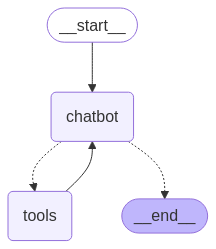

In [46]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [42]:
config = {"configurable": {"thread_id": "1"}}

In [47]:
user_input = "Hi there! My name is Will."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Will.
================================== Ai Message ==================================

Hello Will, it's nice to meet you!


In [48]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, I remember you said your name is Will.


In [ ]:
# The only difference is we change the `thread_id` here to "2" instead of "1"
events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    {"configurable": {"thread_id": "2"}},
    stream_mode="values",
)
for event in events:
    event["messages"][-1].pretty_print()

In [50]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='1f4e6de3-7808-41c2-a226-2705796202d0'), HumanMessage(content='Hi there! My name is Will.', additional_kwargs={}, response_metadata={}, id='c96f62e6-1cc9-48af-973c-ec9545f1fc26'), AIMessage(content="Hello Will, it's nice to meet you!", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 1007, 'total_tokens': 1020, 'completion_time': 0.023636364, 'prompt_time': 0.035676632, 'queue_time': 0.020426226999999998, 'total_time': 0.059312996}, 'model_name': 'Gemma2-9b-It', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'stop', 'logprobs': None}, id='run-1a51efe8-28c0-4cf6-9fd9-cbde5116f723-0', usage_metadata={'input_tokens': 1007, 'output_tokens': 13, 'total_tokens': 1020}), HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='3a603b20-635a-443d-bde3-1300b8d7d2d7'), AIMes

In [51]:
snapshot.next

()

# part 4